In [2]:
library(dplyr)
library(tidyr)
library(igraph)
library(igraph)
library(readr)
library(networkD3)
library(stringr)
library(ggplot2)
library(RColorBrewer)  # Asegúrate de tener este paquete
library(viridis)


Adjuntando el paquete: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Adjuntando el paquete: ‘igraph’


The following object is masked from ‘package:tidyr’:

    crossing


The following objects are masked from ‘package:dplyr’:

    as_data_frame, groups, union


The following objects are masked from ‘package:stats’:

    decompose, spectrum


The following object is masked from ‘package:base’:

    union


Cargando paquete requerido: viridisLite



In [3]:
# Cargar el archivo CSV (ajusta la ruta y nombre del archivo)
archivo <- "/home/usuario/DMT1/scopus_DMT1.csv"
datos <- read_csv(archivo)

Rows: 69 Columns: 32
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (23): Authors, Author full names, Author(s) ID, Title, Source title, Iss...
dbl  (7): Year, Volume, Page start, Page end, Page count, Cited by, PubMed ID
lgl  (2): Editors, ISBN

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [4]:
# Definir una función para extraer los países de una afiliación
extraer_paises <- function(afiliaciones) {
  # Separar las afiliaciones por punto y coma
  partes <- str_split(afiliaciones, ";")[[1]]
  
  # Extraer el país de cada parte
  paises <- str_extract(partes, "[A-Z][a-z]+(?: [A-Z][a-z]+)*$")  # Extraer el último nombre que se considera el país
  return(na.omit(unique(trimws(paises))))  # Retornar países únicos, eliminando NA y espacios en blanco
}

# Aplicar la función a todas las afiliaciones
paises_extraidos <- sapply(datos$Affiliations, extraer_paises)

# Convertir la lista resultante en un vector plano
paises_vector <- unique(unlist(paises_extraidos))

In [5]:
names(paises_extraidos) <- NULL

In [6]:
# Supongamos que `funct_extrac_afiliation` es una función que extrae afiliaciones
# y devuelve un vector de caracteres con los países.
datos$paises <- paises_extraidos

# Convertir la lista de países en un dataframe expandido
datos_expandidos <- datos %>%
  unnest(paises) %>%  # Expandir la lista de países
  mutate(paises = trimws(paises))  # Opcional: eliminar espacios en blanco alrededor de los nombres de países

# Ver el resultado
class(datos_expandidos)

[1] "tbl_df"     "tbl"        "data.frame"

In [7]:
# Convertir en dataframe
datos_df <- as.data.frame(datos_expandidos)

In [11]:
# Calcular las colaboraciones entre países y su frecuencia
colaboraciones <- datos_df %>%
  filter(!is.na(paises)) %>%      # Filtrar los casos sin países
  unnest(paises) %>%              # Separar los países
  group_by(Title) %>%             # Agrupar por título de artículo
  summarize(
    colaboraciones = list({
      unique_paises <- unique(paises)
      if (length(unique_paises) >= 2) {
        combn(unique_paises, 2, simplify = FALSE)
      } else {
        NULL
      }
    })
  ) %>%
  filter(!sapply(colaboraciones, is.null)) %>% # Filtrar combinaciones nulas
  unnest(colaboraciones)

# Convertir los pares en un dataframe adecuado para un grafo
edges <- do.call(rbind, colaboraciones$colaboraciones)
colnames(edges) <- c("Pais1", "Pais2")

# Ordenar alfabéticamente los nombres de los países para evitar duplicados
edges_sorted <- data.frame(
  Pais1 = pmin(edges[,1], edges[,2]),
  Pais2 = pmax(edges[,1], edges[,2])
)

# Contar las ocurrencias de cada par de países
edges_count <- edges_sorted %>%
  group_by(Pais1, Pais2) %>%  # Agrupar por las columnas
  summarise(Count = n()) %>%  # Contar las ocurrencias
  arrange(desc(Count))         # Ordenar por el conteo en orden descendente

`summarise()` has grouped output by 'Pais1'. You can override using the
`.groups` argument.


In [20]:
# Crear el grafo
grafo <- graph_from_data_frame(d=edges_count[1:20,], directed=FALSE)

# Crear una función para simular el efecto 3D en los nodos
add_shadow <- function(colors, intensity = 0.8) {
  # Hacer que los bordes sean más oscuros para simular un efecto de sombra
  darker_colors <- adjustcolor(colors, intensity)
  return(darker_colors)
}

# Asignar colores de los nodos
vertex_colors <- "lightgreen"
vertex_border_colors <- add_shadow(vertex_colors)

# Definir el layout para mayor separación
layout <- layout_with_fr(grafo)

png("/home/usuario/DMT1/DMT1_grafo_scopus.png", width = 2000, height = 1500, res = 300)  # Ajusta width, height y res según tus necesidades
# Visualizar el grafo con efecto de sombra (simulando 3D)
plot(grafo, 
     layout = layout,                  # Usar el layout definido
     vertex.label = V(grafo)$name, 
     vertex.size = 30,                 # Tamaño de los nodos
     vertex.color = vertex_colors,     # Color de los nodos
     vertex.frame.color = vertex_border_colors, # Bordes más oscuros para simular 3D
     edge.width = 1,
     vertex.label.color = "black",     # Color de las etiquetas
     vertex.label.cex = 0.8,           # Tamaño de las etiquetas
     vertex.label.font = 2             # Negrita
)
dev.off()

pdf 
  2

In [16]:
# Pasamos a caracteres la lista de países
datos_df$paises <- paste(datos_df$paises)

# Suponiendo que tu dataframe se llama 'df'
# Agrupar por 'Year' y 'paises' y contar el número de publicaciones
df_summary <- datos_df %>%
  group_by(Year, paises) %>%
  summarise(Production = n(), .groups = 'drop')  # Contar el número de publicaciones

# Ver los datos resumidos
print(df_summary)


# A tibble: 70 × 3
    Year paises         Production
   <dbl> <chr>               <int>
 1  2014 Poland                  1
 2  2016 Germany                 1
 3  2016 United Kingdom          2
 4  2016 United States           2
 5  2017 Egypt                   1
 6  2017 Japan                   1
 7  2017 Poland                  1
 8  2017 United Kingdom          1
 9  2018 Belgium                 1
10  2018 Italy                   1
# ℹ 60 more rows


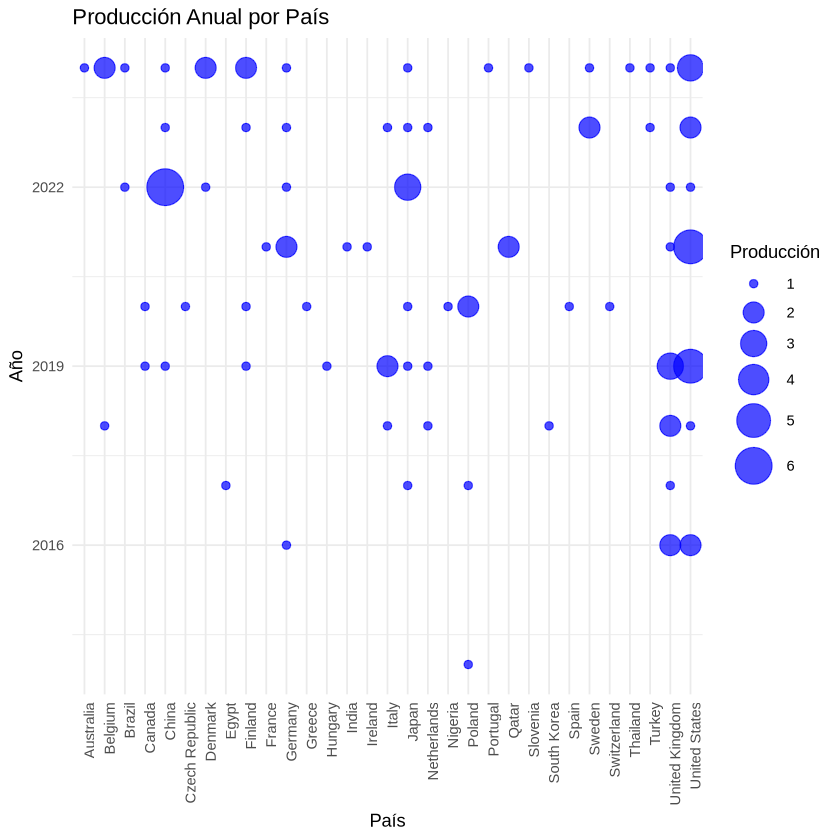

In [17]:
# Crear el gráfico con un color fijo
ggplot(df_summary, aes(x = paises, y = Year, size = Production)) +
  geom_point(alpha = 0.7, color = "blue") +  # Ajusta el color de los puntos
  scale_size(range = c(2, 10), name = "Producción") +  # Ajusta el rango del tamaño de los puntos
  labs(title = "Producción Anual por País",
       x = "País",
       y = "Año") +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 90, hjust = 1))  # Ajustar el ángulo del texto del eje x

In [19]:
png("/home/usuario/DMT1/DMT1_burbuja_scopus.png", width = 2500, height = 2500, res = 300)  # Ajusta width, height y res según tus necesidades
df_summary %>% 
  #filter(Production > 5) %>% 
  ggplot(aes(x = paises, y = Year, size = Production, color = paises)) +  
  geom_point(alpha = 0.7, show.legend = FALSE) +  # Quitar la leyenda de los países
  scale_size(range = c(2, 10), name = "Producción") + 
  labs(title = "",
       x = "País",
       y = "Año") +
  theme_minimal() +
  theme(
    axis.text.x = element_text(angle = 90, hjust = 1, size = 14),  # Aumentar tamaño del texto del eje x
    axis.text.y = element_text(size = 14),  # Aumentar tamaño del texto del eje y
    axis.title.x = element_text(size = 14),  # Aumentar tamaño del título del eje x
    axis.title.y = element_text(size = 14)   # Aumentar tamaño del título del eje y
  ) + 
  scale_color_viridis_d() +  # Usar la paleta viridis para más colores
  scale_y_continuous(breaks = seq(floor(min(df_summary$Year)), ceiling(max(df_summary$Year)), by = 1))  # Eje y solo con enteros
dev.off()

pdf 
  2